# Analyze experimental image of MoS$_2$



In [1]:
%matplotlib inline
import sys
sys.path.append('..')
import matplotlib.pyplot as plt
from matplotlib_scalebar.scalebar import ScaleBar
from glob import glob
import numpy as np
import tensorflow as tf
import tensorflow.keras as keras
from temnn.knet import Unet
from temnn.data.mods import local_normalize

import matplotlib.pyplot as plt
# Peak detection
from stm.preprocess import normalize
from stm.feature.peaks import find_local_peaks, refine_peaks
from skimage.morphology import disk
from scipy.spatial import cKDTree as KDTree
import sys
import os
from collections import deque
import hyperspy.api as hs
import skimage.io
import skimage.color
import json

/home/modules/software/Python/3.8.6-GCCcore-10.2.0/lib/python3.8/site-packages/cryptography/hazmat/bindings/openssl/binding.py:173: CryptographyDeprecationWarning: OpenSSL version 1.0.2 is no longer supported by the OpenSSL project, please upgrade. The next version of cryptography will drop support for it.
  warnings.warn(


Where do we load the neural network parameters from?

In [2]:
graph_dir = '../workflow/trained_networks/MoS2_supported_lores_15pm'
graph_file = 'model-0'
    
graph_path = os.path.join(graph_dir, graph_file)

Where do we load the experimental image from?

The file should be a .png, .dm3 or .dm4 file.   The .dm3 is not well tested.

In [3]:
#imagefile = '/work3/jasc/Pei2/P2_1/Hour_00/Minute_00/Second_10/Au_CeO2_P2_1_Hour_00_Minute_00_Second_10_Frame_0000.dm4'
imagefile = 'FFS6b_Def_-1nm.dm3'
sampling = 0.02275 * 10  # Å per pixel

In [4]:
if imagefile.endswith('.dm3') or imagefile.endswith('.dm4'):
    a = hs.load(imagefile)
    image = a.data
else:
    a = skimage.io.imread(imagefile)
    image = skimage.color.rgb2gray(a)
    # The following critically depends on how the image was created!
    image = skimage.transform.rescale(image, 2.4, multichannel=False)
print(image.shape)
image_size = image.shape[1:]
print(image_size)

(162, 1024, 1024)
(1024, 1024)


In [5]:
a.metadata

├── General
│   ├── FileIO
│   │   └── 0
│   │       ├── hyperspy_version = 1.7.0
│   │       ├── io_plugin = hyperspy.io_plugins.digital_micrograph
│   │       ├── operation = load
│   │       └── timestamp = 2022-05-30T20:33:22.907403+02:00
│   ├── original_filename = FFS6b_Def_-1nm.dm3
│   └── title = FFS6b_Def_-1nm
└── Signal
    ├── Noise_properties
    │   └── Variance_linear_model
    │       ├── gain_factor = 0.2494262307882309
    │       └── gain_offset = 0.0
    ├── quantity = Electrons (Counts)
    └── signal_type =

In [6]:
# Must be divisible by 8
#image_size = tuple(np.array(image_size) // 8 * 8)
#print(image_size)
#image = image[:image_size[0],:image_size[1]]
#print(image.shape, image.dtype)

## Test plot of data

(3, 1024, 1024)
(304, 304, 3)


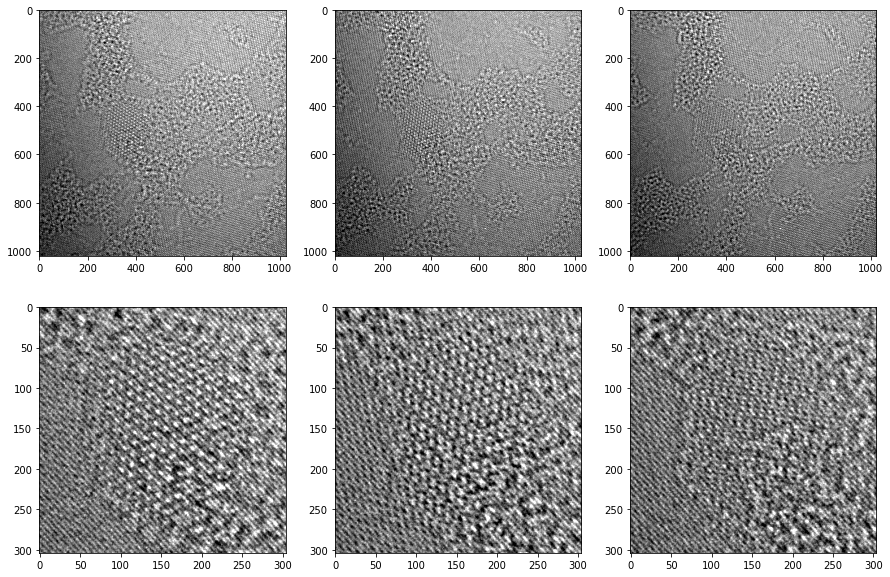

In [7]:
delta = 9
start = 10

labeldefocus = [303, 253, 203]

#delta = -9
#start = 28
frames = np.array((start, start+delta, start+2*delta))
selection = image[frames]
print(selection.shape)
# Crop it
selection2 = selection[:,350:654,200:504]
image_size = selection2.shape[1:]
selection2 = selection2.transpose(1, 2, 0)
print(selection2.shape)
# Plot it
mean = np.mean(selection)
stddev = np.std(selection)
fig, ax = plt.subplots(2,3,figsize=(15,10))
for i in range(3):
    ax[0][i].imshow(selection[i], vmin=mean-2*stddev, vmax=mean+2*stddev, cmap='gray')
    ax[1][i].imshow(selection2[:,:,i], vmin=mean-2*stddev, vmax=mean+2*stddev, cmap='gray')
    #ax[i].axis('off')

In [8]:

print("Using CNN in", graph_path)
model = keras.models.load_model(graph_path)

Using CNN in ../workflow/trained_networks/MoS2_supported_lores_15pm/model-0


In [9]:
img2 = local_normalize(selection2, 120, 120)

In [10]:
img2.shape, img2.max(), img2.min()

((304, 304, 3), 6.012536503607923, -3.5702961184996043)

In [11]:
img2.shape = (1,) + image_size + (3,)
predictions = model.predict(img2)
print(predictions.shape)
predictions = predictions[0]

(1, 304, 304, 2)


## Plot the exit function

Values in [-0.11277467757463455, 0.7437475919723511]


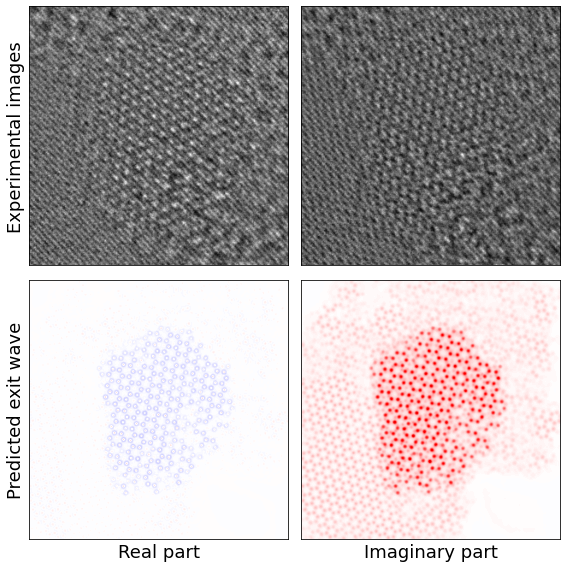

In [12]:
maxval = predictions.max()
minval = predictions.min()
print("Values in [{}, {}]".format(minval, maxval))
maxval = symval = max(-minval, maxval)
maxval = 1.08
minval = -maxval
fs = 18  # Font size for labels

fig, ax = plt.subplots(2,2,figsize=(8,8))
for i in range(2):
    ax[0][i].imshow(img2[0,:,:,i], cmap='gray') 
                    #vmin=mean-2*stddev, vmax=mean+2*stddev)
    ax[1][i].imshow(predictions[:,:,i], cmap='seismic', 
                    vmax = maxval, vmin = minval)

    for j in range(2):
        ax[j][i].set_xticks([])
        ax[j][i].set_yticks([])

ax[0][0].set_ylabel('Experimental images', fontsize=fs)
ax[1][0].set_ylabel('Predicted exit wave', fontsize=fs)
ax[1][0].set_xlabel('Real part', fontsize=fs)
ax[1][1].set_xlabel('Imaginary part', fontsize=fs)

plt.tight_layout()
#plt.savefig('MoS2_Experimental_{}_{}_{}'.format(*tuple(frames)), dpi=300)
None  

## Make a alternative plot, with all three images.

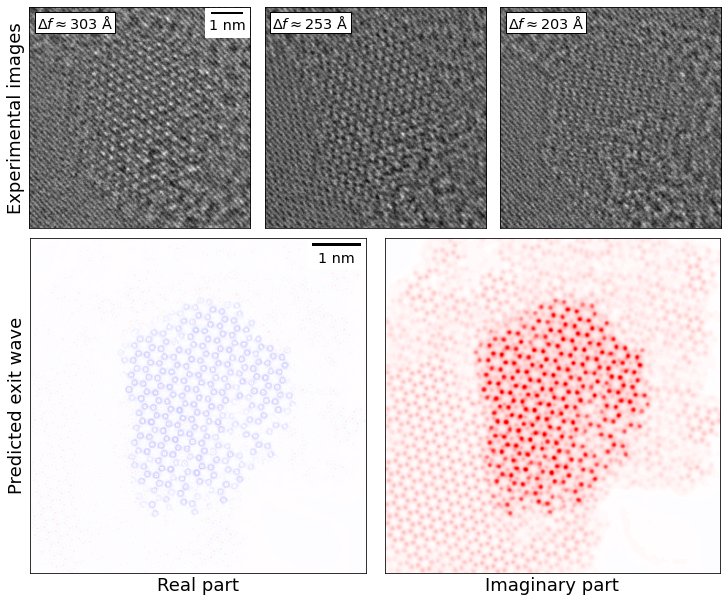

In [13]:
fig = plt.figure(figsize=(10,8.3), constrained_layout=True)
gs0 = fig.add_gridspec(2, 1, wspace=0.0, hspace=0.0, height_ratios=[1, 1.55])
row0 = gs0[0].subgridspec(1, 3, wspace=0.05, hspace=0.0)
row1 = gs0[1].subgridspec(1, 2, wspace=0.1, hspace=0.0)
ax0 = [fig.add_subplot(row0[i]) for i in range(3)]
ax1 = [fig.add_subplot(row1[i]) for i in range(2)]

for i in range(3):
    ax0[i].imshow(img2[0,:,:,i], cmap='gray') 
    ax0[i].set_xticks([])
    ax0[i].set_yticks([])
    ax0[i].text(10, 10, 
                  f'$\\Delta f \\approx {labeldefocus[i]:.0f}$ Å',
                  ha='left', va='top',
                  bbox=dict(fc='white', ec=None, boxstyle='square,pad=0.15'),
                  fontsize = 0.8 * fs)
    
for i in range(2):
    ax1[i].imshow(predictions[:,:,i], cmap='seismic', 
                  vmax = maxval, vmin = minval)
    ax1[i].set_xticks([])
    ax1[i].set_yticks([])

ax0[0].set_ylabel('Experimental images', fontsize=fs)
ax1[0].set_ylabel('Predicted exit wave', fontsize=fs)
ax1[0].set_xlabel('Real part', fontsize=fs)
ax1[1].set_xlabel('Imaginary part', fontsize=fs)

# Place a scalebar
scalebar1 = ScaleBar(0.1*sampling, 'nm', fixed_value=1, pad=0.4, font_properties={'size': 0.8 * fs})
ax0[0].add_artist(scalebar1)
scalebar1 = ScaleBar(0.1*sampling, 'nm', fixed_value=1, pad=0.4, font_properties={'size': 0.8 * fs})
ax1[0].add_artist(scalebar1)

#plt.tight_layout()
plt.savefig('MoS2_Experimental_{}_{}_{}'.format(*tuple(frames)), dpi=300)